# **Übung 6: Wirbelleiterverfahren**

In [366]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import IntSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### 6.1.1 Visualisierung Pfeilflügel

In [367]:
def pfeilfluegel(s, phi, c=1) -> np.array:
    """Generiert die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    shift = s * np.arctan(np.radians(phi))

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, shift], [s, c + shift], [0, c], 
        [-s, c + shift], [-s, shift], [0, 0]])
    
    return points


def plot_pfeilfluegel(s, phi):
    """Plottet die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    
    # Flügeleckpunkte generieren
    points = pfeilfluegel(s, phi)

    # Geometrie plotten
    plt.figure(figsize=(7, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Pfeilflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()


def widget_pfeilfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_s = VBox([Label('Halbspannweite [m]'), IntSlider(value=3, min=1, max=20)])
    slider_phi = VBox([Label('Pfeilwinkel [deg]'), IntSlider(value=15, min=0, max=60)])

    # Interaktiver plot
    ui = VBox([slider_s, slider_phi])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_pfeilfluegel, {'s': slider_s.children[1], 'phi': slider_phi.children[1]})

    return HBox([out, ui])

In [368]:
display(widget_pfeilfluegel())

### 6.1.2 Geometrische Parameter und Randbedinungen

In [369]:
# Konstant
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 10                      # Spannweite
s = b/2                     # Halbspannweite
c = 1                       # Flügeltiefe
aspect_ratio = 20           # Streckung
U_inf = 10                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)
rho = 1                     # Luftdichte (in kg/m^3)
k_Gamma = 0.25              # Skalierung der Wirbelposition
k_A = 0.75                  # Skalierung des Aufpunkts

### 6.1.3 Vernetzen des Tragflügels

In [370]:
N = 80                       # Anzahl horizontaler Panel
M = 20                       # Anzahl vertikaler Panel

In [371]:
def plot_diskretisierung_pfeil(N, M, s=3, phi=15, c=1):
    """Plottet die Diskretisierung eines gepfeilten Rechteckflügels auf Basis der Anzahl der Elementarflügel"""

    points = pfeilfluegel(s, phi)
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, c, M+1)
    
    # Geometrie plotten
    plt.figure(figsize=(6, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Panele plotten
    for i in range(N+1):
        shift = abs(y_values[i]) * np.arctan(np.radians(phi))
        plt.plot([y_values[i], y_values[i]], [shift, shift + c], 'g-', linewidth=0.5)

    for j in range(M+1):
        plt.plot([-s, 0, s], [x_values[j] + shift, x_values[j], x_values[j] + shift], 'g-', linewidth=0.5)
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Pfeilflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()


def widget_diskretisierung_pfeil():
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl horizontaler Panel'), IntSlider(value=20, min=1, max=100)])
    slider_M = VBox([Label('Anzahl vertikaler Panel'), IntSlider(value=5, min=1, max=60)])

    # Interaktiver plot
    ui = VBox([slider_N, slider_M])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_pfeil, {'N': slider_N.children[1], 'M': slider_M.children[1]})
    return HBox([out, ui])

In [372]:
display(widget_diskretisierung_pfeil())

Flügeltiefe (c): 0.50 m
Flügelfläche (S): 5.00 m^2
Induzierte Geschwindigkeit: [5.20944533 5.20944533 5.20944533 5.20944533 5.20944533 5.20944533
 5.20944533 5.20944533 5.20944533 5.20944533]
Auftrieb (L): 0.00 N


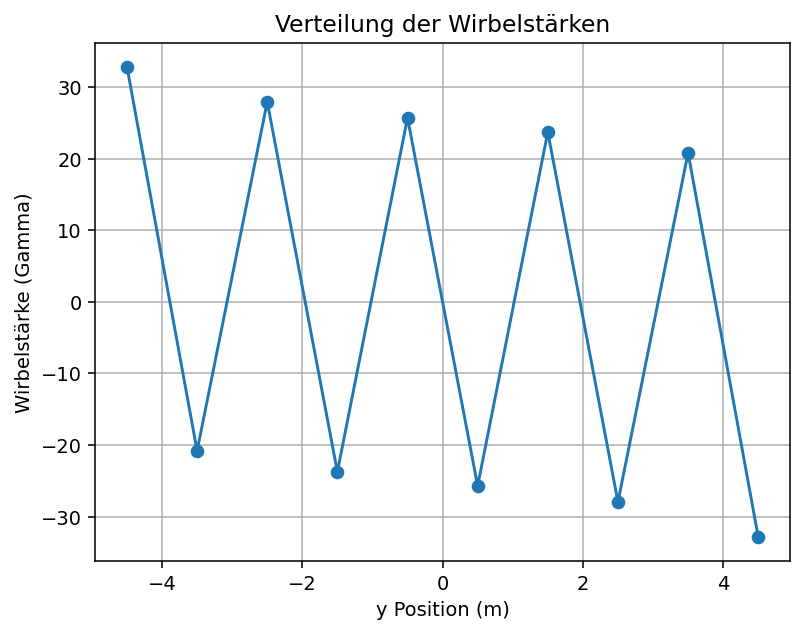

In [373]:
import numpy as np
import matplotlib.pyplot as plt

# Eingabedaten
phi = np.radians(15)  # Pfeilungswinkel (in radians)
b = 10  # Flügelbreite (in meters)
aspect_ratio = 20  # Streckung
V = 30  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(10)  # Anstellwinkel (in radians)
rho = 1  # Luftdichte (in kg/m^3)

# Berechnung der Flügeltiefe (c) und Flügelfläche (S)
c = b / aspect_ratio
S = b * c

# Diskretisierung des Flügels
n_panels = 10  # Anzahl horizontaler Panels
dy = b / n_panels

# Berechnung der Positionen der Kontrollpunkte und Wirbel
y_control = np.linspace(-b/2 + dy/2, b/2 - dy/2, n_panels)
y_vortex = np.linspace(-b/2, b/2, n_panels + 1)

# Initialisierung der Einflussmatrix und RHS-Vektor
A = np.zeros((n_panels, n_panels))
RHS = np.zeros(n_panels)

# Einflusskoeffizienten berechnen
for i in range(n_panels):
    for j in range(n_panels):
        if i != j:
            A[i, j] = 1 / (2 * np.pi) * np.log((y_control[i] - y_vortex[j])**2 / (y_control[i] - y_vortex[j+1])**2)

# RHS-Vektor (freie Strömungskomponente)
RHS[:] = V * np.sin(alpha)

# Lösung des Gleichungssystems
gamma = np.linalg.solve(A, RHS)

# Berechnung der induzierten Geschwindigkeit und Auftrieb
induced_velocity = np.dot(A, gamma)
L = rho * V * np.sum(gamma * dy)

# Ergebnisse ausgeben
print(f"Flügeltiefe (c): {c:.2f} m")
print(f"Flügelfläche (S): {S:.2f} m^2")
print(f"Induzierte Geschwindigkeit: {induced_velocity}")
print(f"Auftrieb (L): {L:.2f} N")

# Plotten der Wirbelstärken
plt.plot(y_vortex[:-1] + dy/2, gamma, 'o-')
plt.xlabel('y Position (m)')
plt.ylabel('Wirbelstärke (Gamma)')
plt.title('Verteilung der Wirbelstärken')
plt.grid()
plt.show()


IndexError: index 16 is out of bounds for axis 0 with size 16

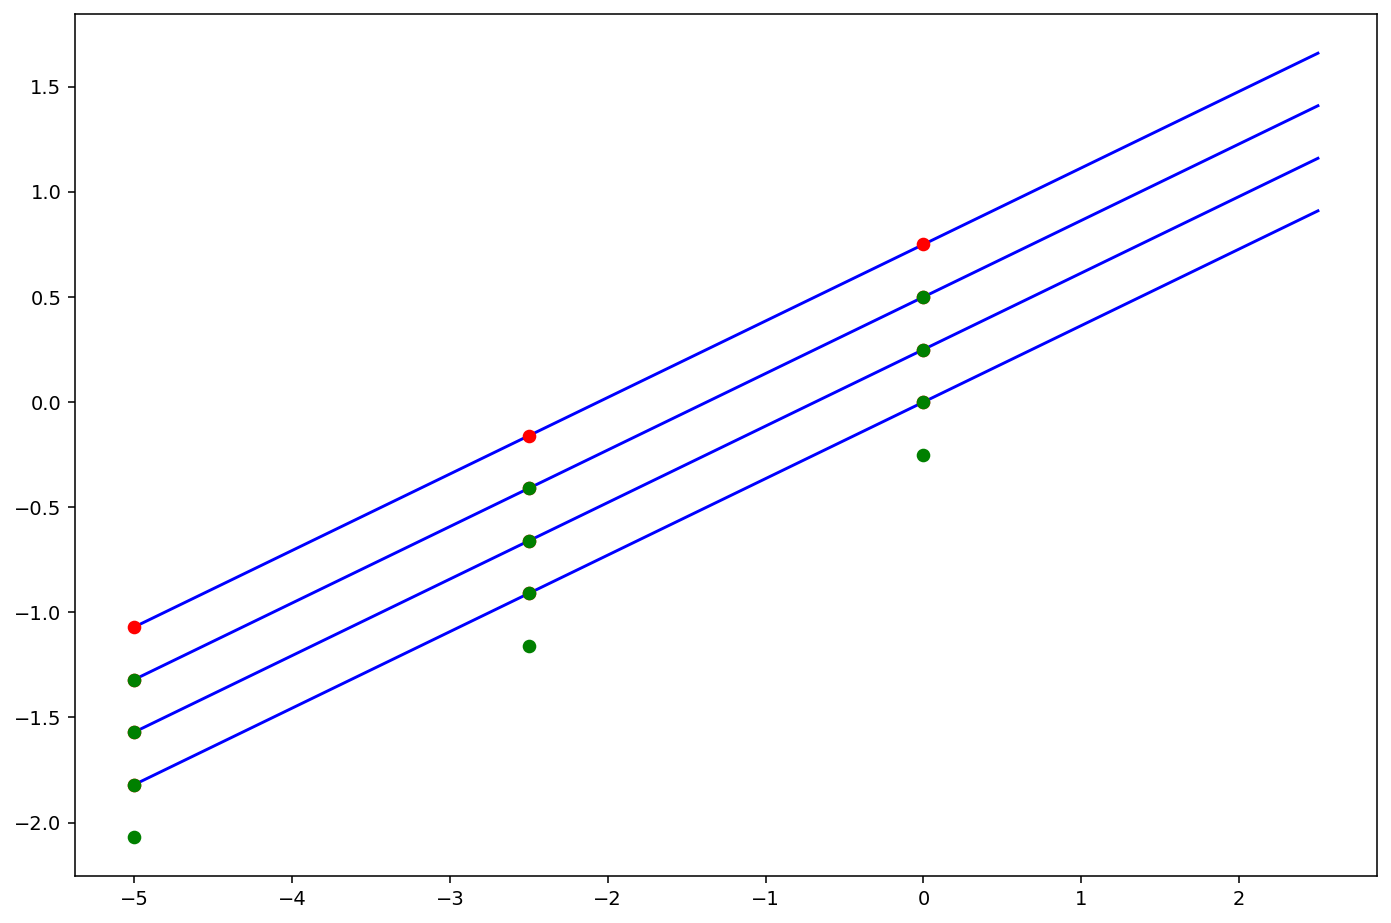

In [374]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
n_spanwise_panels = 4  # Anzahl der Panels in Spannweite (y-Richtung)
n_chordwise_panels = 4  # Anzahl der Panels in Flügeltiefe (x-Richtung)
span = 10.0  # Spannweite des Flügels
chord_length = 1.0  # Flügeltiefe
sweep_angle = np.radians(20)  # Pfeilwinkel in Grad

# Erzeugen von Kontrollpunkten und Wirbellinien
y_positions = np.linspace(-span/2, span/2, n_spanwise_panels + 1)  # Positionen entlang der Spannweite
x_chords = np.linspace(0, chord_length, n_chordwise_panels + 1)  # Positionen entlang der Flügeltiefe

# Erstellen von Arrays für Kontrollpunkte und Wirbellinien
control_points = []
vortices = []

# Berechnung der Positionen
for i in range(n_spanwise_panels):
    for j in range(n_chordwise_panels):
        y = y_positions[i]
        x = x_chords[j]
        
        # X-Position für Kontrollpunkt und Wirbellinie
        x_control = x + y * np.tan(sweep_angle)
        x_vortex = x_control - 0.25 * chord_length
        
        # Hinzufügen der Kontrollpunkte und Wirbellinien
        control_points.append([x_control, y])
        vortices.append([x_vortex, y])

control_points = np.array(control_points)
vortices = np.array(vortices)

# Plot erstellen
plt.figure(figsize=(12, 8))

# Vertauschen der x- und y-Koordinaten für die Plot-Darstellung
for i in range(n_spanwise_panels + 1):
    for j in range(n_chordwise_panels + 1):
        index = i * (n_chordwise_panels + 1) + j
        if j < n_chordwise_panels:
            next_index = index
            plt.plot([control_points[index, 1], control_points[next_index, 1]], 
                     [control_points[index, 0], control_points[next_index, 0]], 'b-')  # Panel horizontal
        if i < n_spanwise_panels:
            next_index = index + (n_chordwise_panels)
            plt.plot([control_points[index, 1], control_points[next_index, 1]], 
                     [control_points[index, 0], control_points[next_index, 0]], 'b-')  # Panel vertikal

        plt.plot(control_points[index, 1], control_points[index, 0], 'ro')  # Kontrollpunkte
        plt.plot(vortices[index, 1], vortices[index, 0], 'go')  # Wirbellinien

# Anpassen der Achsen und Labels
plt.xlabel('y-Koordinate (m)')
plt.ylabel('x-Koordinate (m)')
plt.title('Diskretisierte Flügelplanform mit Panels und Kontrollpunkten (Drehung um 90 Grad)')
plt.gca().invert_yaxis()  # Invertieren der y-Achse für die Anströmung von oben
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
